In [1]:
# --- 0. Environment & Utils
import math, time, random, os, psutil
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt

from datasets import load_dataset  # HuggingFace datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 1337
def set_seed(seed=SEED):
    random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def max_cuda_mem_mb():
    if device.type == "cuda":
        return torch.cuda.max_memory_allocated()/(1024**2)
    return 0.0

set_seed()
print("Device:", device)


Device: cuda


In [2]:
# --- 1. Data (WikiText-2)
ds = load_dataset("wikitext", "wikitext-2-raw-v1")
train_text = " ".join(ds["train"]["text"])
val_text   = " ".join(ds["validation"]["text"])
test_text  = " ".join(ds["test"]["text"])

from collections import Counter

def build_vocab(text: str, min_freq: int = 2):
    cnt = Counter(text.split())
    toks = [(w,c) for (w,c) in cnt.items() if c>=min_freq]
    toks.sort(key=lambda x: (-x[1], x[0]))
    stoi = {w:i for i,(w,_) in enumerate(toks)}
    stoi["<unk>"] = len(stoi)
    itos = {i:w for w,i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab(train_text, min_freq=2)
vocab_size = len(stoi)
print("Vocab size:", vocab_size)

def encode_words(text: str, stoi: Dict[str,int]) -> torch.Tensor:
    return torch.tensor([stoi.get(w, stoi["<unk>"]) for w in text.split()], dtype=torch.long)

train_ids = encode_words(train_text, stoi)
val_ids   = encode_words(val_text, stoi)
test_ids  = encode_words(test_text, stoi)

# BPTT batchification
bptt = 128
batch_size = 32

def batchify(data: torch.Tensor, bsz: int):
    nbatch = data.size(0) // bsz
    data = data[:nbatch*bsz]
    return data.view(bsz, -1).t().contiguous().to(device)

train_data = batchify(train_ids, batch_size)
val_data   = batchify(val_ids, batch_size)
test_data  = batchify(test_ids, batch_size)

def get_batch(src: torch.Tensor, i: int, bptt: int):
    seq_len = min(bptt, src.size(0)-1-i)
    data = src[i:i+seq_len]          # (T,B)
    target = src[i+1:i+1+seq_len]    # (T,B)
    return data, target.reshape(-1)  # (T*B,)


Vocab size: 44562


In [3]:
# --- 2.1 RMSNorm (Llama)
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (..., d)
        rms = x.pow(2).mean(dim=-1, keepdim=True).add(self.eps).sqrt()
        x_norm = x / rms
        return self.weight * x_norm

# --- 2.2 SwiGLU (Llama FFN 활성)
class SwiGLU(nn.Module):
    def __init__(self, dim: int, mult: int = 4, bias=False):
        super().__init__()
        inner = mult * dim
        self.w12 = nn.Linear(dim, inner*2, bias=bias)  # to [A|B]
        self.w3  = nn.Linear(inner, dim, bias=bias)
    def forward(self, x):
        a,b = self.w12(x).chunk(2, dim=-1)
        # Swish = SiLU = x * sigmoid(x)
        return self.w3( torch.nn.functional.silu(a) * torch.sigmoid(b) )

# --- 2.3 RoPE (Rotary Positional Embeddings)
def rope_get_inv_freq(dim: int, theta: float = 10000.0, device=None):
    # dim must be even
    half = dim // 2
    inv_freq = 1.0 / (theta ** (torch.arange(0, half, device=device).float() / half))
    return inv_freq

def rope_rotate_half(x):
    # (B, H, T, D) where D is even; split into (D/2,D/2)
    x1, x2 = x[..., :x.size(-1)//2], x[..., x.size(-1)//2:]
    return torch.cat([-x2, x1], dim=-1)

def rope_apply(q, k, seq_len: int, base_theta: float = 10000.0):
    # q,k: (B,H,T,D)
    device = q.device
    d = q.size(-1)
    inv_freq = rope_get_inv_freq(d, theta=base_theta, device=device)   # (D/2,)
    t = torch.arange(seq_len, device=device).float()                   # (T,)
    freqs = torch.einsum("t,d->t d", t, inv_freq)                      # (T, D/2)
    # expand to (B,H,T,D)
    cos = torch.cos(freqs)[None, None, :, :].repeat(q.size(0), q.size(1), 1, 1)
    sin = torch.sin(freqs)[None, None, :, :].repeat(q.size(0), q.size(1), 1, 1)
    # interleave cos/sin to match D
    cos = torch.cat([cos, cos], dim=-1)
    sin = torch.cat([sin, sin], dim=-1)
    q_rot = (q * cos) + (rope_rotate_half(q) * sin)
    k_rot = (k * cos) + (rope_rotate_half(k) * sin)
    return q_rot, k_rot

# --- Quick unit checks
with torch.no_grad():
    x = torch.randn(2, 8, 64, device=device)
    print("RMSNorm out:", RMSNorm(64).to(device)(x).shape)
    print("SwiGLU out:", SwiGLU(64, mult=2).to(device)(x).shape)


RMSNorm out: torch.Size([2, 8, 64])
SwiGLU out: torch.Size([2, 8, 64])


In [4]:
# --- 3.1 SWA layer selection (논문 취지: first/middle/last = Global)
def select_global_layers(n_layers: int) -> List[int]:
    if n_layers <= 2:
        return [0, n_layers-1]
    mid = n_layers // 2
    return sorted(set([0, mid, n_layers-1]))

# --- 3.2 SWA mask (causal + local band)
def build_swa_mask(seq_len: int, window: int, device):
    mask = torch.full((seq_len, seq_len), float("-inf"), device=device)
    for i in range(seq_len):
        start = max(0, i - window + 1)
        mask[i, start:i+1] = 0
    return mask  # (T,T)

# --- 3.3 KV-cache pair sharing
class KVCachePool:
    def __init__(self, share_pairs: bool = True):
        self.share_pairs = share_pairs
        self.store: Dict[int, Tuple[torch.Tensor, torch.Tensor]] = {}
    def _key(self, layer_idx: int) -> int:
        return layer_idx // 2 if self.share_pairs else layer_idx
    def get(self, layer_idx: int):
        return self.store.get(self._key(layer_idx), None)
    def set(self, layer_idx: int, kv: Tuple[torch.Tensor, torch.Tensor]):
        self.store[self._key(layer_idx)] = kv
    def clear(self):
        self.store.clear()

# --- 3.4 Meta Token
class MetaToken(nn.Module):
    def __init__(self, d_model: int, n_meta: int = 2, enabled: bool = True):
        super().__init__()
        self.enabled = enabled
        self.n_meta = n_meta if enabled else 0
        if enabled:
            self.meta = nn.Parameter(torch.randn(1, n_meta, d_model)*0.02)
    def forward(self, x):  # x: (B,T,D)
        if not self.enabled: return x
        B = x.size(0)
        return torch.cat([self.meta.expand(B,-1,-1), x], dim=1)

# --- Quick unit checks
with torch.no_grad():
    print("Global layers(6):", select_global_layers(6))
    print("SWA mask:", build_swa_mask(8, 4, device).shape)
    mt = MetaToken(32, n_meta=2, enabled=True).to(device)
    print("Meta add:", mt(torch.randn(2,10,32, device=device)).shape)


Global layers(6): [0, 3, 5]
SWA mask: torch.Size([8, 8])
Meta add: torch.Size([2, 12, 32])


In [5]:
# --- 4. SelfAttentionKV (with RoPE + KV share)
class SelfAttentionKV(nn.Module):
    def __init__(self, d_model: int, n_heads: int, attn_drop=0.0, rope_theta: float = 10000.0):
        super().__init__()
        assert d_model % n_heads == 0
        self.h = n_heads
        self.d = d_model // n_heads
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.out = nn.Linear(d_model, d_model, bias=False)
        self.drop = nn.Dropout(attn_drop)
        self.rope_theta = rope_theta
        self.norm = RMSNorm(d_model)  # Llama: pre-norm

    def _shape(self, x):  # (B,T,D)->(B,H,T,d)
        B,T,D = x.shape
        return x.view(B,T,self.h,self.d).transpose(1,2)

    def forward(self, x, attn_mask=None, kv_pool: Optional[KVCachePool]=None, layer_idx: Optional[int]=None):
        B,T,D = x.shape
        h = self.norm(x)

        q = self._shape(self.Wq(h))
        k = self._shape(self.Wk(h))
        v = self._shape(self.Wv(h))

        # RoPE (apply on q,k)
        q, k = rope_apply(q, k, seq_len=T, base_theta=self.rope_theta)

        # KV share (pair-wise): reuse k,v within layer-pair when present
        if kv_pool is not None and layer_idx is not None:
            cached = kv_pool.get(layer_idx)
            if cached is not None:
                k, v = cached
            else:
                kv_pool.set(layer_idx, (k.detach(), v.detach()))

        scores = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(self.d)  # (B,H,T,T)
        if attn_mask is not None:
            scores = scores + attn_mask  # (T,T) broadcast to (B,H,T,T)

        attn = F.softmax(scores, dim=-1)
        attn = self.drop(attn)

        ctx = torch.matmul(attn, v)   # (B,H,T,d)
        ctx = ctx.transpose(1,2).contiguous().view(B,T,D)
        return self.out(ctx), attn


In [6]:
# --- 5.1 Mamba-SSM (mamba_ssm 사용)
def make_mamba(d_model: int):
    try:
        from mamba_ssm import Mamba
        return Mamba(d_model, d_state=16, d_conv=4, expand=2).to(device)
    except Exception as e:
        raise RuntimeError(
            "mamba_ssm가 필요합니다. GPU 환경 및 mamba-ssm 설치를 확인하세요."
        ) from e

# --- 5.2 HybridHead
class HybridHead(nn.Module):
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.attn = SelfAttentionKV(d_model, n_heads)
        self.ssm  = make_mamba(d_model)
        self.g_attn = nn.Parameter(torch.tensor(1.0))
        self.g_ssm  = nn.Parameter(torch.tensor(1.0))
    def forward(self, x, attn_mask=None, kv_pool: Optional[KVCachePool]=None, layer_idx: Optional[int]=None):
        a,_ = self.attn(x, attn_mask=attn_mask, kv_pool=kv_pool, layer_idx=layer_idx)
        s   = self.ssm(RMSNorm(x.size(-1)).to(x.device)(x))  # pre-norm for SSM branch
        return self.g_attn*a + self.g_ssm*s

# --- 5.3 Llama FFN (RMSNorm + SwiGLU)
class LlamaFFN(nn.Module):
    def __init__(self, d_model: int, mult: int = 4):
        super().__init__()
        self.norm = RMSNorm(d_model)
        self.ffn  = SwiGLU(d_model, mult=mult)
    def forward(self, x):
        h = self.norm(x)
        return x + self.ffn(h)


In [7]:
# --- 6. HymbaBlock & HymbaModel
class HymbaBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, layer_idx: int,
                 kv_pool: KVCachePool, use_kv_share: bool,
                 is_global: bool, swa_window: int):
        super().__init__()
        self.layer_idx = layer_idx
        self.kv_pool = kv_pool if use_kv_share else None
        self.is_global = is_global
        self.swa_window = swa_window
        self.hybrid = HybridHead(d_model, n_heads)
        self.ffn = LlamaFFN(d_model)

    def forward(self, x):
        T = x.size(1)
        mask = None
        if not self.is_global:
            mask = build_swa_mask(T, self.swa_window, x.device)
            mask = mask.unsqueeze(0).unsqueeze(0)  # (1,1,T,T)
        y = self.hybrid(x, attn_mask=mask, kv_pool=self.kv_pool, layer_idx=self.layer_idx)
        return self.ffn(x + y)

class HymbaModel(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, n_heads: int, n_layers: int,
                 use_meta=True, n_meta=2, use_kv_share=True, swa_window=64):
        super().__init__()
        self.emb  = nn.Embedding(vocab_size, d_model)
        self.meta = MetaToken(d_model, n_meta, enabled=use_meta)
        self.kv_pool = KVCachePool(share_pairs=use_kv_share)
        global_ids = set(select_global_layers(n_layers))
        self.blocks = nn.ModuleList([
            HymbaBlock(d_model, n_heads, i, self.kv_pool, use_kv_share,
                       is_global=(i in global_ids), swa_window=swa_window)
            for i in range(n_layers)
        ])
        self.norm = RMSNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)
        self.use_meta = use_meta
        self.n_meta = n_meta if use_meta else 0

    def forward(self, idx):  # idx: (T,B) long
        x = self.emb(idx.transpose(0,1))  # -> (B,T,D)
        x = self.meta(x)
        if self.kv_pool is not None: self.kv_pool.clear()
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        logits = self.head(x)  # (B,T(+meta),V)
        return logits[:, self.n_meta:, :].transpose(0,1).contiguous()  # (T,B,V)

    def print_layout(self):
        n = len(self.blocks)
        global_ids = set(select_global_layers(n))
        print("| Layer | Attention | KV-group |")
        print("|---|---|---|")
        for i in range(n):
            print(f"| {i} | {'Global' if i in global_ids else 'Sliding'} | {i//2} |")


In [11]:
with torch.no_grad(), autocast("cuda"):
    model = HymbaModel(vocab_size, d_model=256, n_heads=4, n_layers=9,
                       use_meta=True, n_meta=2, use_kv_share=True, swa_window=64).to(device)
    model.print_layout()

    T,B = 20,2
    x = torch.randint(0, vocab_size, (T,B), device=device)
    y = model(x)
    print("I/O shapes:", x.shape, "->", y.shape)  # (T,B) -> (T,B,V)


| Layer | Attention | KV-group |
|---|---|---|
| 0 | Global | 0 |
| 1 | Sliding | 0 |
| 2 | Sliding | 1 |
| 3 | Sliding | 1 |
| 4 | Global | 2 |
| 5 | Sliding | 2 |
| 6 | Sliding | 3 |
| 7 | Sliding | 3 |
| 8 | Global | 4 |
I/O shapes: torch.Size([20, 2]) -> torch.Size([20, 2, 44562])


In [12]:
# --- 7. Train / Eval / Generate
def evaluate(model, data_src, bptt=128, max_steps=None):
    model.eval()
    total_loss, tok_cnt, steps = 0.0, 0, 0
    crit = nn.CrossEntropyLoss()
    with torch.no_grad():
        for i in range(0, data_src.size(0)-1, bptt):
            data, targets = get_batch(data_src, i, bptt)
            with autocast(device_type="cuda", enabled=(device.type=="cuda")):
                out = model(data)  # (T,B,V)
                loss = crit(out.view(-1, out.size(-1)), targets)
            total_loss += loss.item() * data.numel()
            tok_cnt += data.numel()
            steps += 1
            if max_steps and steps >= max_steps: break
    avg = total_loss / max(1,tok_cnt)
    return avg, math.exp(avg)

def train_epoch(model, data_src, lr=3e-4, bptt=128, max_steps=300):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    scaler = GradScaler(enabled=(device.type=="cuda"))
    crit = nn.CrossEntropyLoss()
    losses=[]; t0=time.time(); step=0
    for i in range(0, data_src.size(0)-1, bptt):
        data, targets = get_batch(data_src, i, bptt)
        opt.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", enabled=(device.type=="cuda")):
            out = model(data)
            loss = crit(out.view(-1, out.size(-1)), targets)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        losses.append(loss.item())
        step+=1
        if step%50==0: print(f"step {step:04d} loss {loss.item():.4f}")
        if step>=max_steps: break
    return sum(losses)/len(losses), time.time()-t0

@torch.no_grad()
def generate(model, prompt: str, max_new_tokens=40):
    model.eval()
    toks = torch.tensor([[stoi.get(w, stoi["<unk>"]) for w in prompt.split()]], device=device).t()
    for _ in range(max_new_tokens):
        with autocast(device_type="cuda", enabled=(device.type=="cuda")):
            logits = model(toks)          # (T,B,V)
            nxt = torch.argmax(logits[-1], dim=-1, keepdim=True)
        toks = torch.cat([toks, nxt], dim=0)
    return " ".join(itos.get(int(i), "<unk>") for i in toks.squeeze(1).tolist())


In [18]:
# --- 7.2 Ablation Runner
# --- Updated Config
@dataclass
class CFG:
    d_model: int = 512
    n_heads: int = 8
    n_layers: int = 9
    swa_window: int = 128
    use_meta: bool = True
    n_meta: int = 4
    use_kv_share: bool = True
    epochs: int = 5
    lr: float = 3e-4
    bptt: int = 256
    batch_size: int = 64
    max_steps: Optional[int] = 300  # None = full epoch

# --- Scheduler-aware train loop
def train_epochs(model, train_data, cfg: CFG):
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=cfg.epochs)
    scaler = GradScaler(enabled=(device.type=="cuda"))
    crit = nn.CrossEntropyLoss()
    hist = []

    for ep in range(cfg.epochs):
        model.train()
        losses=[]
        t0=time.time()
        for i in range(0, train_data.size(0)-1, cfg.bptt):
            data, targets = get_batch(train_data, i, cfg.bptt)
            opt.zero_grad(set_to_none=True)
            with autocast(device_type="cuda", enabled=(device.type=="cuda")):
                out = model(data)
                loss = crit(out.view(-1, out.size(-1)), targets)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            losses.append(loss.item())
        sched.step()
        avg = sum(losses)/len(losses)
        val_loss, val_ppl = evaluate(model, val_data, bptt=cfg.bptt)
        t1=time.time()
        hist.append(dict(epoch=ep+1, train_loss=avg, val_loss=val_loss, ppl=val_ppl, time=t1-t0))
        print(f"[ep {ep+1}] train {avg:.3f}  val {val_loss:.3f}  ppl {val_ppl:.2f}  time {t1-t0:.1f}s")
    return hist

# --- Build & train
cfg = CFG()
train_data = batchify(train_ids, cfg.batch_size)
val_data   = batchify(val_ids, cfg.batch_size)

model = HymbaModel(vocab_size, d_model=cfg.d_model, n_heads=cfg.n_heads,
                   n_layers=cfg.n_layers, use_meta=cfg.use_meta, n_meta=cfg.n_meta,
                   use_kv_share=cfg.use_kv_share, swa_window=cfg.swa_window).to(device)

hist = train_epochs(model, train_data, cfg)


def build_model(cfg: CFG):
    return HymbaModel(
        vocab_size=vocab_size, d_model=cfg.d_model, n_heads=cfg.n_heads, n_layers=cfg.n_layers,
        use_meta=cfg.use_meta, n_meta=cfg.n_meta, use_kv_share=cfg.use_kv_share, swa_window=cfg.swa_window
    ).to(device)

def run_one(title: str, cfg: CFG, train_data, val_data):
    print(f"\n==== {title} ====")
    model = build_model(cfg)
    model.print_layout()
    tr_loss, tr_time = train_epoch(model, train_data, lr=cfg.lr, bptt=bptt, max_steps=cfg.max_steps)
    val_loss, val_ppl = evaluate(model, val_data, bptt=bptt, max_steps=120)
    sample = generate(model, "the king", max_new_tokens=32)
    torch.cuda.synchronize() if device.type=="cuda" else None
    mem = max_cuda_mem_mb()
    print(f"[{title}] train_loss={tr_loss:.4f}  val_loss={val_loss:.4f}  PPL={val_ppl:.2f}  time={tr_time:.1f}s  mem={mem:.1f}MB")
    return dict(title=title, train_loss=tr_loss, val_loss=val_loss, ppl=val_ppl, time=tr_time, mem=mem, sample=sample)


[ep 1] train 5.355  val 2.293  ppl 9.91  time 29.6s
[ep 2] train 1.518  val 0.729  ppl 2.07  time 29.6s
[ep 3] train 0.644  val 0.401  ppl 1.49  time 29.7s
[ep 4] train 0.392  val 0.302  ppl 1.35  time 29.8s
[ep 5] train 0.306  val 0.276  ppl 1.32  time 29.9s


In [19]:
# --- Generation test after training
prompt = "the history of science"
print("Prompt:", prompt)
sample = generate(model, prompt, max_new_tokens=50)
print("Generated:", sample)


Prompt: the history of science
Generated: the history of science science science science science science science science science science science science science science science science science science science science science science the the the science science science science science science science science science science science science science science science science science science science science science science science science science science



==== BASE ====
| Layer | Attention | KV-group |
|---|---|---|
| 0 | Global | 0 |
| 1 | Sliding | 0 |
| 2 | Sliding | 1 |
| 3 | Sliding | 1 |
| 4 | Global | 2 |
| 5 | Sliding | 2 |
| 6 | Sliding | 3 |
| 7 | Sliding | 3 |
| 8 | Global | 4 |
step 0050 loss 5.6125
step 0100 loss 3.6537
step 0150 loss 2.3821
step 0200 loss 1.6375
step 0250 loss 1.2324
[BASE] train_loss=3.6248  val_loss=0.9863  PPL=2.68  time=32.1s  mem=22322.5MB

==== NO-KVSHARE ====
| Layer | Attention | KV-group |
|---|---|---|
| 0 | Global | 0 |
| 1 | Sliding | 0 |
| 2 | Sliding | 1 |
| 3 | Sliding | 1 |
| 4 | Global | 2 |
| 5 | Sliding | 2 |
| 6 | Sliding | 3 |
| 7 | Sliding | 3 |
| 8 | Global | 4 |
step 0050 loss 5.6165
step 0100 loss 3.7066
step 0150 loss 2.3352
step 0200 loss 1.6004
step 0250 loss 1.1909
[NO-KVSHARE] train_loss=3.6190  val_loss=1.5028  PPL=4.49  time=32.3s  mem=22322.5MB

==== NO-META ====
| Layer | Attention | KV-group |
|---|---|---|
| 0 | Global | 0 |
| 1 | Sliding | 0 |
| 2 | Sliding | 1 |
| 3 |

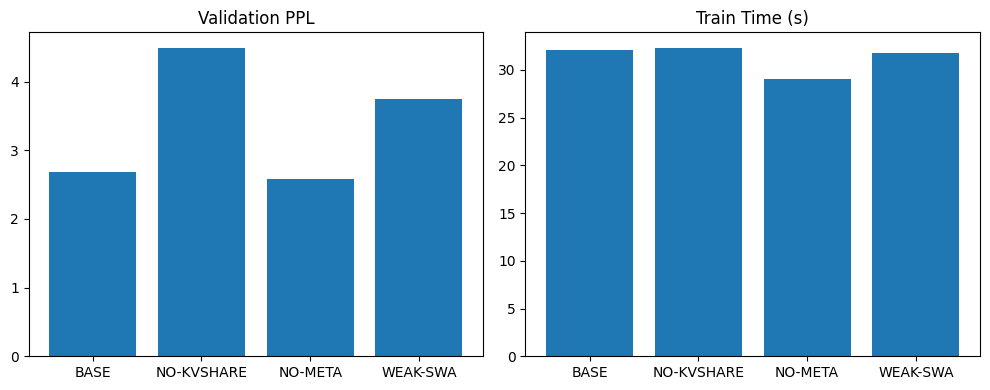

In [20]:
# --- Run ablation variants
results = []
base_cfg = CFG()

results.append(run_one("BASE", base_cfg, train_data, val_data))
results.append(run_one("NO-KVSHARE", CFG(**{**base_cfg.__dict__, "use_kv_share": False}), train_data, val_data))
results.append(run_one("NO-META", CFG(**{**base_cfg.__dict__, "use_meta": False}), train_data, val_data))
results.append(run_one("WEAK-SWA", CFG(**{**base_cfg.__dict__, "swa_window": 512}), train_data, val_data))

# --- 시각화
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("Validation PPL"); plt.bar([r["title"] for r in results], [r["ppl"] for r in results])
plt.subplot(1,2,2); plt.title("Train Time (s)"); plt.bar([r["title"] for r in results], [r["time"] for r in results])
plt.tight_layout(); plt.show()


SelfAttentionKV OK: torch.Size([2, 12, 64])
Model I/O test: torch.Size([16, 2, 44562])

==== BASE: partial-SWA + KVshare + Meta + Hybrid ====
| Layer | Attention | KV-group |
|---|---|---|
| 0 | Global | 0 |
| 1 | Sliding | 0 |
| 2 | Sliding | 1 |
| 3 | Global | 1 |
| 4 | Sliding | 2 |
| 5 | Global | 2 |
step 0050 loss 7.1505
step 0100 loss 6.5645
step 0150 loss 5.8466
step 0200 loss 5.2927
[BASE: partial-SWA + KVshare + Meta + Hybrid] train_loss=6.7915  val_loss=4.9424  PPL=140.11  time=13.8s  mem=22322.5MB

==== NO-KVSHARE ====
| Layer | Attention | KV-group |
|---|---|---|
| 0 | Global | 0 |
| 1 | Sliding | 0 |
| 2 | Sliding | 1 |
| 3 | Global | 1 |
| 4 | Sliding | 2 |
| 5 | Global | 2 |
step 0050 loss 7.1089
step 0100 loss 5.3738
step 0150 loss 4.0786
step 0200 loss 3.0994
[NO-KVSHARE] train_loss=5.7240  val_loss=2.7951  PPL=16.36  time=12.3s  mem=22322.5MB

==== NO-META ====
| Layer | Attention | KV-group |
|---|---|---|
| 0 | Global | 0 |
| 1 | Sliding | 0 |
| 2 | Sliding | 1 |
|

,title,train_loss,val_loss,ppl,time,mem
0,BASE: partial-SWA + KVshare + Meta + Hybrid,6.791541,4.942437,140.111330,13.849981,22322.521484
1,NO-KVSHARE,5.723982,2.795079,16.363918,12.315482,22322.521484
2,NO-META,6.648269,4.720787,112.256619,11.875211,22322.521484
3,WEAK-SWA(window=256),6.708763,4.916606,136.538428,12.096437,22322.521484


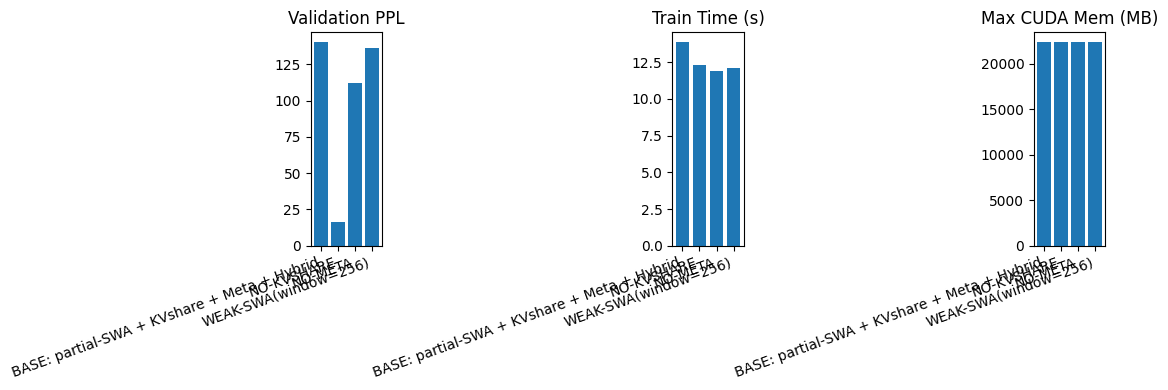


--- BASE: partial-SWA + KVshare + Meta + Hybrid
the king the first the the first the the the the the the the the the the the the the the the the the the the the the the the the the the the

--- NO-KVSHARE
the king during during during during during during during during during during during during during during during during during during during during during were were were were were were were were were were were

--- NO-META
the king the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

--- WEAK-SWA(window=256)
the king at at at at at at at at at at the the at the the the the the the the the the the the the the the the the the the the


In [21]:
# --- 8.1 Component smoke tests
with torch.no_grad():
    # SWA / KV / Meta quick checks already done above
    sa = SelfAttentionKV(64, 4).to(device)
    y,_ = sa(torch.randn(2,12,64, device=device))
    print("SelfAttentionKV OK:", y.shape)

# --- 8.2 Integrated I/O test
with torch.no_grad(), autocast(device_type="cuda", enabled=(device.type=="cuda")):
    mtest = HymbaModel(vocab_size, d_model=128, n_heads=4, n_layers=6,
                       use_meta=True, n_meta=2, use_kv_share=True, swa_window=32).to(device)
    x = torch.randint(0, vocab_size, (16,2), device=device)
    out = mtest(x)
    print("Model I/O test:", out.shape)

# --- 8.3 Ablation runs
base = CFG(d_model=256, n_heads=4, n_layers=6, swa_window=64, use_meta=True, n_meta=2, use_kv_share=True, max_steps=200)
results = []
results.append(run_one("BASE: partial-SWA + KVshare + Meta + Hybrid", base, train_data, val_data))
results.append(run_one("NO-KVSHARE", CFG(**{**base.__dict__, "use_kv_share": False}), train_data, val_data))
results.append(run_one("NO-META", CFG(**{**base.__dict__, "use_meta": False}), train_data, val_data))
results.append(run_one("WEAK-SWA(window=256)", CFG(**{**base.__dict__, "swa_window": 256}), train_data, val_data))

# --- 8.4 표+시각화
try:
    import pandas as pd
    from IPython.display import display
    df = pd.DataFrame([{k:v for k,v in r.items() if k!="sample"} for r in results])
    display(df)
except Exception as e:
    print("Results:", [{k:v for k,v in r.items() if k!='sample'} for r in results])

plt.figure(figsize=(11,4))
plt.subplot(1,3,1); plt.title("Validation PPL"); plt.bar([r["title"] for r in results], [r["ppl"] for r in results]); plt.xticks(rotation=20, ha="right")
plt.subplot(1,3,2); plt.title("Train Time (s)"); plt.bar([r["title"] for r in results], [r["time"] for r in results]); plt.xticks(rotation=20, ha="right")
plt.subplot(1,3,3); plt.title("Max CUDA Mem (MB)"); plt.bar([r["title"] for r in results], [r["mem"] for r in results]); plt.xticks(rotation=20, ha="right")
plt.tight_layout(); plt.show()

# 샘플 생성 텍스트 일부 출력
for r in results:
    print("\n---", r["title"])
    print(r["sample"][:300])
